In [1]:
#Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import glob

import cv2 as cv
from PIL import Image
from osgeo import gdal

import torch 
import torch.nn as nn

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

from train_unet import * #load dataset and model classes

fig_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Interpreting UNet/Figures/{}.png'

In [2]:
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    
    return rgb_normalize

def load_train(path):
    """Returns sentinal image, rgb image and label"""
    
    label_path = path.replace("images","labels").replace("image","chip")
   
    img = np.load(path)
    rgb_img = get_rgb(img)
    label = np.load(label_path)[0]
    
    return img, rgb_img, label


def plot_label(path):
    """Diplays RGB image and label"""
    
    if 'train' in path: 
        img, rgb_img, label = load_train(path)
    elif 'test' in path: 
        img, rgb_img, label = load_test(path)

    #Display
    fig,axs = plt.subplots(1,2,figsize=(15,15))
    fig.patch.set_facecolor('xkcd:white')

    axs[0].imshow(rgb_img)
    axs[0].axis("off")
    
    axs[1].imshow(label,cmap="BrBG")
    axs[1].axis("off")



In [3]:
train_path = "../../data/SWED/train/images/" #UPDATE

TRANSFORMS = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

paths = glob.glob(train_path + "*")
paths = random.choices(paths, k=1000)

# Remove paths with no data
def check_img(path):
    img = np.load(path)
    # Check if the image is NOT all zeros
    test = (np.max(img) + np.min(img) != 0)
    return test

paths = [path for path in paths if check_img(path)]

# Shuffle the paths
random.shuffle(paths)

# Create a datasets for training and validation
valid_data = TrainDataset(paths, TRANSFORMS,scale=True)

# Prepare data for Pytorch model
valid_loader = DataLoader(valid_data, batch_size=32)

print("Validation images: {}".format(valid_data.__len__()))

Validation images: 915


In [4]:
#Test validation accuracy

# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# Load saved model 
model = torch.load('../../models/UNET-FULL-21FEB23.pth', map_location=torch.device('cpu') )
model.eval()
model.to(device)

# Calculate validation loss
model = model.eval()

criterion = nn.CrossEntropyLoss()

Using device: mps



In [5]:
iterator = iter(valid_loader)
images, target = next(iterator)
images, target = next(iterator)

images = images.to(device)
target = target.squeeze().to(device)

output = model(images)
#output = nn.Softmax(dim=1)(output)

loss = criterion(output, target)
print(loss.item())

0.4326954782009125


In [6]:
output[0][0] + output[0][1]


/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       device='mps:0', grad_fn=<AddBackward0>)

In [16]:
target[0]

/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='mps:0')

In [15]:
images[0].min()

tensor(-1.7462e-09, device='mps:0')

In [6]:
for i,t in enumerate(target):
    if t.min() < 0:
        print(i)

In [ ]:
  # Get target
mask_path = path.replace("images","labels").replace("image","chip")
mask = np.load(mask_path)

In [7]:
mask_path = paths[0].replace("images","labels").replace("image","chip")
mask = np.load(mask_path)

mask.min()
print(set(mask.flatten()))

{0, 1}


In [8]:
for i, path in enumerate(paths):
    
   
    mask_set = set(mask.flatten())

    if mask_set not in [set([0,1]),set([0]),set([1])]:
        print(i, mask_set)

[[[ 1  1  1 ... -1 -1 -1]
  [ 1  1  1 ... -1 -1 -1]
  [ 1  1  1 ... -1 -1 -1]
  ...
  [ 1  1  1 ... -1 -1 -1]
  [ 1  1  1 ... -1 -1 -1]
  [ 1  1  1 ... -1 -1 -1]]]


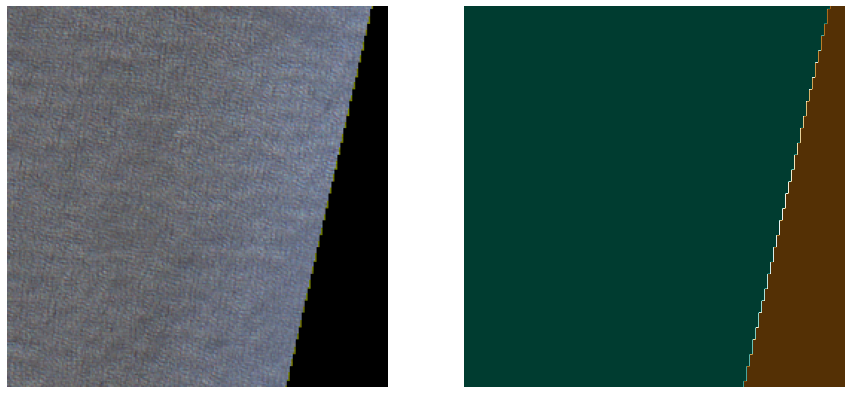

In [21]:
n = 337
mask_path = paths[n].replace("images","labels").replace("image","chip")
mask = np.load(mask_path)
print(mask)


plot_label(paths[n])